In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#for neural network
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.models import Sequential, Model, load_model
from keras.layers import Reshape, Dense, Input
from sklearn.model_selection import train_test_split
import keras_tuner as kt

import sys
np.set_printoptions(threshold=sys.maxsize)

In [2]:

physical_devices = tf.config.list_physical_devices('GPU')
print("Number of GPUs:", len(physical_devices))

# If GPUs are available, check logical devices
if physical_devices:
  logical_devices = tf.config.list_logical_devices('GPU')
  print("Number of logical GPUs:", len(logical_devices))


Number of GPUs: 1
Number of logical GPUs: 1


2024-06-10 08:21:58.649820: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-10 08:21:58.649886: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-06-10 08:21:58.649908: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-06-10 08:21:58.650322: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-10 08:21:58.650351: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("Metal is enabled for TensorFlow!")
else:
    print("Metal is not enabled for TensorFlow.")


Metal is enabled for TensorFlow!


# data

In [4]:
df=pd.read_csv('/Users/vedantgupta/Documents/summer project/data-analysis-with-technical-indicators-1/nifty_sensex_close_data/data/Maruti_2011_to_2023.csv')

In [5]:
df_close=df['Maruti_Close']
df_close
df_close = df_close.astype(float)
df_close.shape

n=615 #number of data points
w=124 #window size
#training array
trainval_arr_inp=np.zeros([n-w,w]) #input array

#filling the input array
for i in range (n-w):
    for j in range(w):
        trainval_arr_inp[i][j]=df_close[i+j]

#output array
trainval_arr_out=np.array([df_close[i+w] for i in range(n-w)])
trainval_arr_out=trainval_arr_out.reshape(n-w,1)
trainval_arr_out.shape

trainval_arr=np.column_stack((trainval_arr_inp,trainval_arr_out)) #training array

#shuffle the rows
np.random.seed(0)
np.random.shuffle(trainval_arr)

In [6]:
train_arr=trainval_arr[:int(0.7*(n-w)),:] #training array
val_arr=trainval_arr[int(0.7*(n-w)):,:] #validation array

X_train=train_arr[:,:-1]
y_train=train_arr[:,-1]

X_val=val_arr[:,:-1]
y_val=val_arr[:,-1]

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(343, 124)
(343,)
(148, 124)
(148,)


In [7]:
testadata = np.zeros(w)
for i in range(w):
    testadata[i] = df_close[n+i]
testdata = testadata.reshape(1, w)
print(testdata.shape)

df_close[n+w]

(1, 124)


1626.5335693359375

# model

In [8]:
initalizer2 = keras.initializers.HeNormal

In [9]:
# Clear existing model
tf.keras.backend.clear_session()

In [10]:
def model_builder(hp):
  model = keras.Sequential()
  act = hp.Choice('activation', values=['relu','sigmoid', 'tanh'])
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  hl = hp.Int('layers', min_value=2, max_value=6, step=1)
  model.add(Dense(hp_units, input_shape=(w,), activation=act, name = 'Input'))
  for i in range(hl):
    model.add(Dense(units=hp_units, activation=act))
  model.add(Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mse',metrics=['mape'] )
  return model

In [11]:
tuner = kt.Hyperband(model_builder,objective=kt.Objective("val_mape", direction="min"),max_epochs=10,factor=3,directory='my_dir_maruti',project_name='intro_to_kt')

PermissionDeniedError: my_dir_maruti; Read-only file system

In [10]:
tuner.search(X_train,y_train, epochs=100, batch_size=25, validation_data=(X_val,y_val))

Trial 30 Complete [00h 00m 01s]
val_mape: 84.15447998046875

Best val_mape So Far: 3.5729687213897705
Total elapsed time: 00h 00m 35s


In [11]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps

In [12]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (Dense)                   │ (None, 288)            │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 288)            │        83,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 288)            │        83,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 288)            │        83,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 288)            │        83,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 288)            │        83,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452,449 (1.73 MB)

 Trainable params: 452,449 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the model
history = model.fit(X_train,y_train,validation_data=(X_val,y_val), epochs=100, batch_size=25)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 389726.3750 - mape: 40.8393 - val_loss: 20023.0273 - val_mape: 11.4401
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24255.6562 - mape: 11.5048 - val_loss: 22346.8887 - val_mape: 9.7768
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17109.9863 - mape: 9.6588 - val_loss: 15799.0840 - val_mape: 8.8146
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12040.8027 - mape: 8.0882 - val_loss: 10368.7734 - val_mape: 8.2083
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8722.0752 - mape: 6.9881 - val_loss: 13287.9092 - val_mape: 7.1044
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9660.7891 - mape: 6.7907 - val_loss: 7328.4839 - val_mape: 5.4203
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6617.2397 - mape: 5.5490 - val_loss: 4079.2117 - val_mape: 4.4079
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4482.3599 - mape: 4.6874 - val_loss: 13378.4023 - val

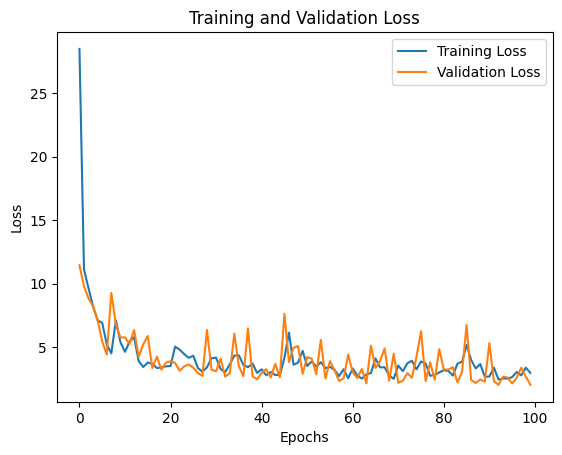

In [14]:
#plotting the training and validation loss
plt.plot(history.history['mape'], label='Training Loss')
plt.plot(history.history['val_mape'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [15]:
y_pred = model.predict(testdata)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


array([[1631.6007]], dtype=float32)

In [16]:
print('predicted value',y_pred)
print('actual value',df_close[n+w])

#mae

mae = np.mean(np.abs(y_pred - df_close[n+w]))
print('mae',mae)

#accuracy

accuracy = 1 - mae/df_close[n+w]
print('accuracy',accuracy)

predicted value [[1631.6007]]
actual value 1626.5335693359375
mae 5.0671387
accuracy 0.9968847008340912
